In [1]:
import os
import pandas as pd
import numpy  as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, kpss

# New Series

## Source and description

<span style="color:green">Full link or name of the provider: </span> https://fred.stlouisfed.org/series/DCOILWTICO \
<span style="color:green">Series code: </span> DCOILWTICO \
<span style="color:green">Date of access: </span>  Dec.01.2024 \
<span style="color:green">Description: </span> Crude Oil Prices: West Texas Intermediate (WTI) - Cushing, Oklahoma, Units: Dollars per Barrel,
Not Seasonally Adjusted

## Characteristics

<span style="color:green"> Periodicity or frequency: </span> Daily  \
<span style="color:green"> Time span: </span> 1986-01-02 to 2024-11-25 \
<span style="color:green"> Number of observations: </span> 10148

We chose Crude Oil Prices: West Texas Intermediate (WTI) - Cushing, Oklahoma because it is a closely related benchmark to Brent Crude Prices, reflecting global and regional oil market dynamics. Including WTI allows us to analyze price correlations between these two major indices, which are influenced by similar economic, geopolitical, and supply-demand factors. This relationship enhances the robustness and predictive power of our analysis for forecasting.

On December 1, 2024, I re-accessed the data from HW1 and downloaded it again from [Crude Oil Prices: Brent - Europe](https://fred.stlouisfed.org/series/DCOILBRENTEU). This updated dataset reflects the most recent information compared to the version I initially downloaded for HW1. The updated data will allow me to align it with a new series I’ve selected.

Next, I will create a DataFrame with three columns:

- Time: The timeline for the data.
- Crude Oil Prices: Brent - Europe: The original data from HW1.
- Crude Oil Prices: West Texas Intermediate (WTI) - Cushing, Oklahoma: The newly selected series.

## Pre-processing

We fill missing values using a moving average with a specified window size. Then we detect outliers with IQR method and replace them with moving average.

In [2]:
window_size = 5

# Function to handle missing values and outliers
def clean_data(df, value_column, window_size):
    df[value_column] = pd.to_numeric(df[value_column], errors='coerce')
    df[value_column] = df[value_column].fillna(
        df[value_column].rolling(window=window_size, min_periods=1).mean()
    )
    Q1 = df[value_column].quantile(0.25)
    Q3 = df[value_column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df[value_column] = df[value_column].where(
        (df[value_column] >= lower_bound) & (df[value_column] <= upper_bound),
        other=df[value_column].rolling(window=window_size, min_periods=1).mean()
    )
    return df

# Load and clean Brent Prices
prices_brent = pd.read_csv("./DCOILBRENTEU.csv")
prices_brent.columns = ['date', 'y_brent']
prices_brent['date'] = pd.to_datetime(prices_brent['date'])
prices_brent = clean_data(prices_brent, 'y_brent', window_size)

# Load and clean WTI Prices
prices_wti = pd.read_csv("./DCOILWTICO.csv")
prices_wti.columns = ['date', 'y_wti']
prices_wti['date'] = pd.to_datetime(prices_wti['date'])
prices_wti = clean_data(prices_wti, 'y_wti', window_size)

print(f"Missing values in Brent Prices: {prices_brent.isna().sum().sum()}")
print(f"Missing values in WTI Prices: {prices_wti.isna().sum().sum()}")

Missing values in Brent Prices: 0
Missing values in WTI Prices: 0


In [3]:
# Merge the cleaned Brent and WTI datasets on 'date'
merged_prices = pd.merge(prices_brent, prices_wti, on='date', how='inner')
print("Merged DataFrame:\n", merged_prices.head())
print("Missing values in merged data:\n", merged_prices.isna().sum())
print("Shape of merged data:", merged_prices.shape)

Merged DataFrame:
         date  y_brent    y_wti
0 1987-05-20    18.63  19.7500
1 1987-05-21    18.45  19.9500
2 1987-05-22    18.55  19.6800
3 1987-05-25    18.60  19.8375
4 1987-05-26    18.63  19.3500
Missing values in merged data:
 date       0
y_brent    0
y_wti      0
dtype: int64
Shape of merged data: (9789, 3)


as 9789 is very computationally heavy, we choose first 1000 rows to analyze.

In [4]:
merged_prices = merged_prices.iloc[:1000]

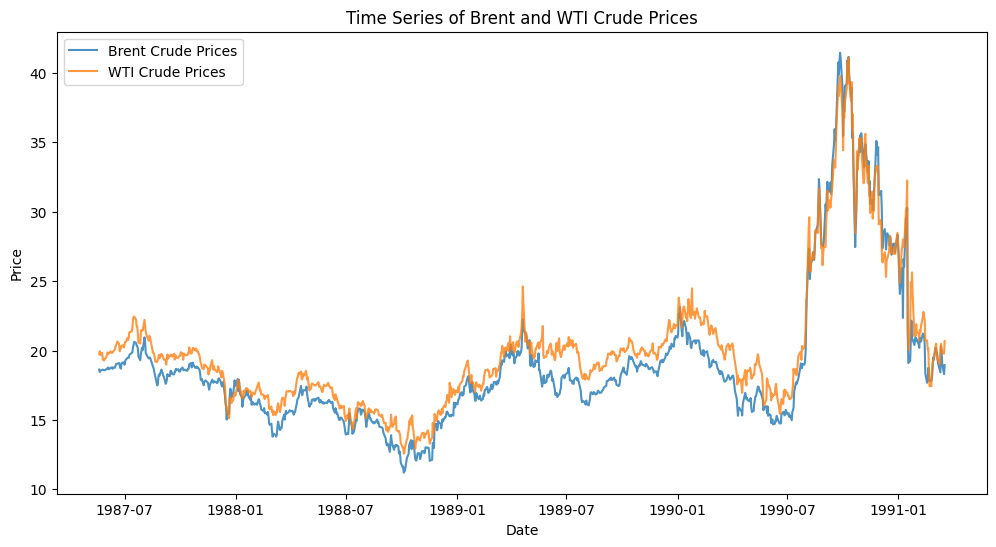

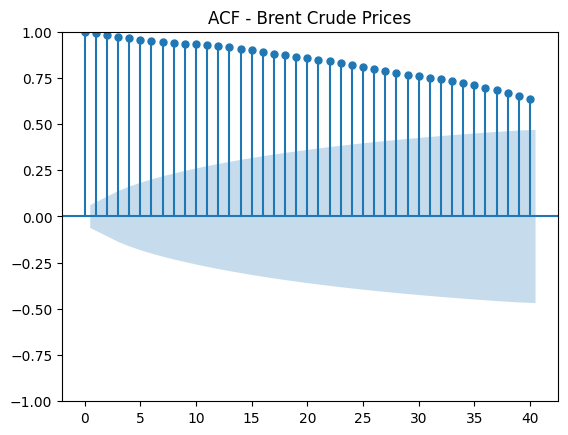

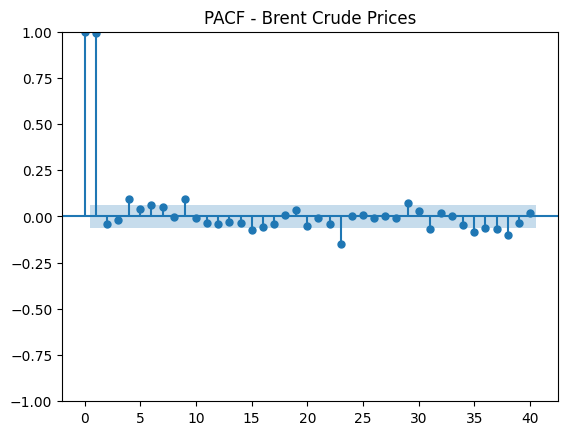

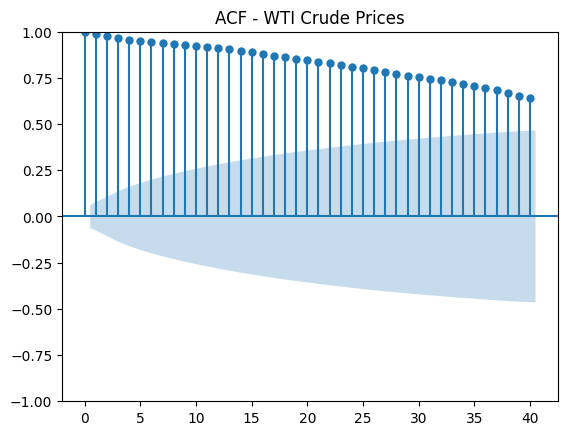

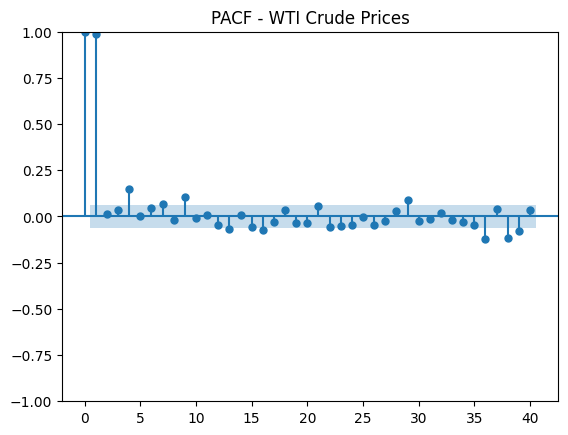

ADF Test for Brent Crude Prices:
ADF Statistic: -2.568394186100116
p-value: 0.09970705855726592
Non-Stationary
--------------------------------------------------
ADF Test for WTI Crude Prices:
ADF Statistic: -2.0462985043711956
p-value: 0.2666487722234856
Non-Stationary
--------------------------------------------------
KPSS Test for Brent Crude Prices:
KPSS Statistic: 1.7159556743119728
p-value: 0.01
Non-Stationary
--------------------------------------------------
KPSS Test for WTI Crude Prices:
KPSS Statistic: 1.875566622908059
p-value: 0.01
Non-Stationary
--------------------------------------------------


/var/folders/l0/k7f2rhdj5xg3__zf2_xlw76c0000gn/T/ipykernel_56247/3562776502.py:37: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series, regression='c', nlags='auto')
/var/folders/l0/k7f2rhdj5xg3__zf2_xlw76c0000gn/T/ipykernel_56247/3562776502.py:37: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series, regression='c', nlags='auto')


In [5]:
# Plotting the time series for Brent and WTI prices
plt.figure(figsize=(12, 6))
plt.plot(merged_prices['date'], merged_prices['y_brent'], label='Brent Crude Prices', alpha=0.8)
plt.plot(merged_prices['date'], merged_prices['y_wti'], label='WTI Crude Prices', alpha=0.8)
plt.title('Time Series of Brent and WTI Crude Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

# Plot ACF and PACF for Brent prices
sm.graphics.tsa.plot_acf(merged_prices['y_brent'], lags=40, title="ACF - Brent Crude Prices")
plt.show()
sm.graphics.tsa.plot_pacf(merged_prices['y_brent'], lags=40, title="PACF - Brent Crude Prices")
plt.show()

# Plot ACF and PACF for WTI prices
sm.graphics.tsa.plot_acf(merged_prices['y_wti'], lags=40, title="ACF - WTI Crude Prices")
plt.show()
sm.graphics.tsa.plot_pacf(merged_prices['y_wti'], lags=40, title="PACF - WTI Crude Prices")
plt.show()

# Perform ADF test for stationarity
def adf_test(series, name):
    result = adfuller(series, autolag='AIC')
    print(f"ADF Test for {name}:")
    print(f"ADF Statistic: {result[0]}")
    print(f"p-value: {result[1]}")
    print("Stationary" if result[1] < 0.05 else "Non-Stationary")
    print("-" * 50)

adf_test(merged_prices['y_brent'], "Brent Crude Prices")
adf_test(merged_prices['y_wti'], "WTI Crude Prices")

# Perform KPSS test for stationarity
def kpss_test(series, name):
    result = kpss(series, regression='c', nlags='auto')
    print(f"KPSS Test for {name}:")
    print(f"KPSS Statistic: {result[0]}")
    print(f"p-value: {result[1]}")
    print("Stationary" if result[1] > 0.05 else "Non-Stationary")
    print("-" * 50)

kpss_test(merged_prices['y_brent'], "Brent Crude Prices")
kpss_test(merged_prices['y_wti'], "WTI Crude Prices")

We clearly see that our data is Non-Stationary. Now we make it Stationary.

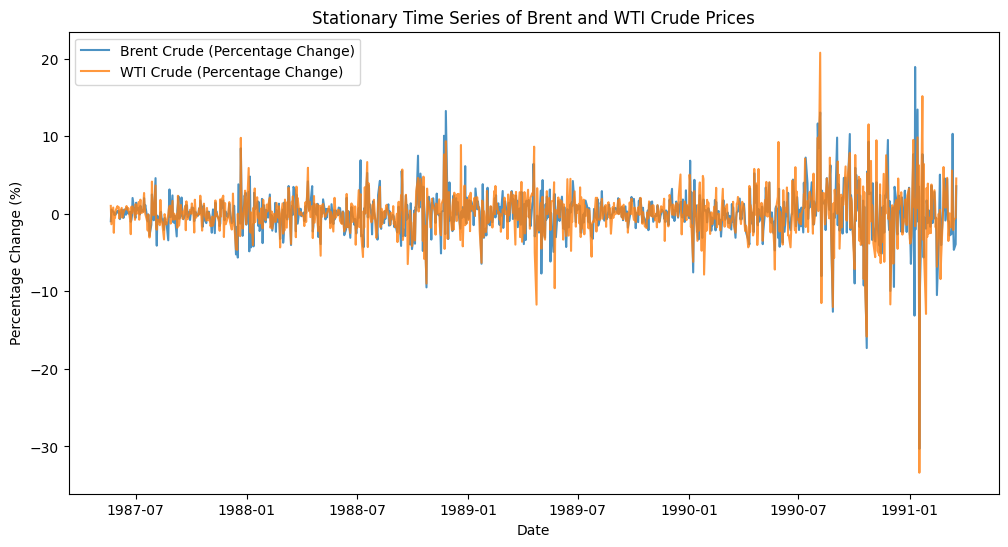

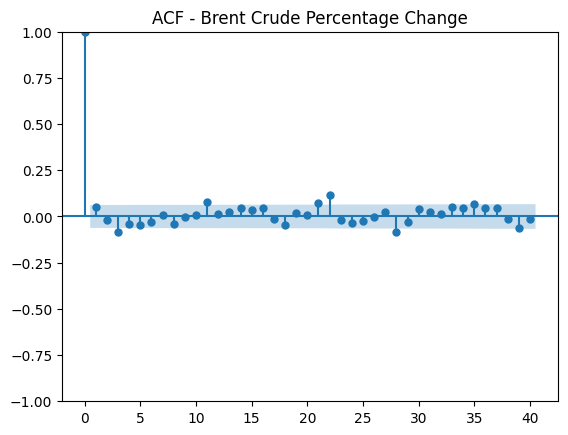

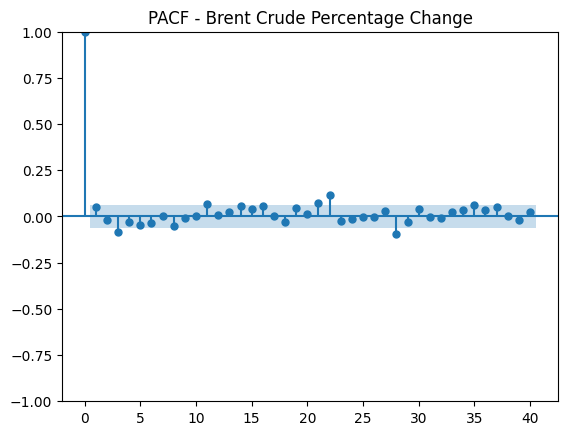

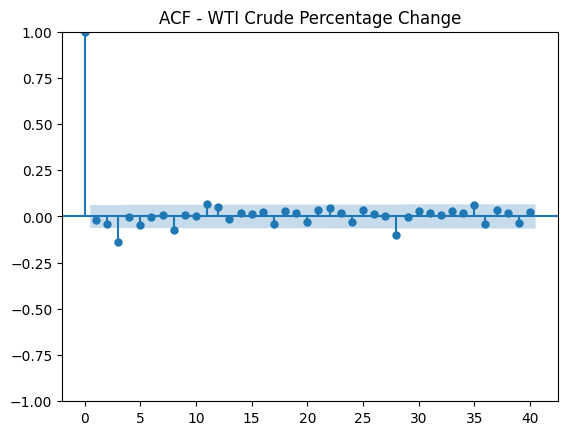

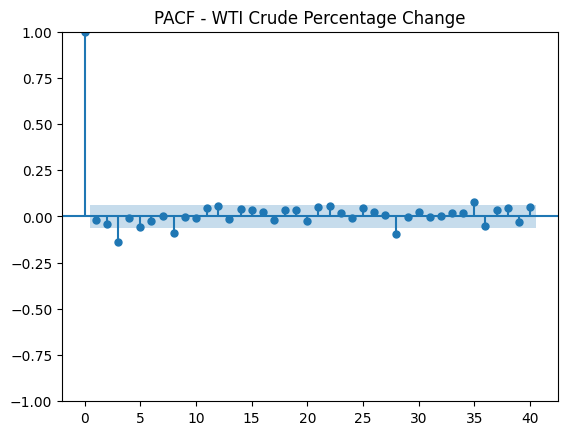

ADF Test for Brent Crude Percentage Change:
ADF Statistic: -4.688759574534004
p-value: 8.834088896999924e-05
Stationary
--------------------------------------------------
ADF Test for WTI Crude Percentage Change:
ADF Statistic: -13.543127788464734
p-value: 2.490911000907579e-25
Stationary
--------------------------------------------------
KPSS Test for Brent Crude Percentage Change:
KPSS Statistic: 0.10005429210285058
p-value: 0.1
Stationary
--------------------------------------------------
KPSS Test for WTI Crude Percentage Change:
KPSS Statistic: 0.10520682929265189
p-value: 0.1
Stationary
--------------------------------------------------


/var/folders/l0/k7f2rhdj5xg3__zf2_xlw76c0000gn/T/ipykernel_56247/3562776502.py:37: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression='c', nlags='auto')
/var/folders/l0/k7f2rhdj5xg3__zf2_xlw76c0000gn/T/ipykernel_56247/3562776502.py:37: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression='c', nlags='auto')


In [6]:
# Apply percentage change to make the series stationary
merged_prices['y_brent_pct'] = merged_prices['y_brent'].pct_change() * 100
merged_prices['y_wti_pct'] = merged_prices['y_wti'].pct_change() * 100

# Drop rows with NaN caused by pct_change
stationary_data = merged_prices.dropna(subset=['y_brent_pct', 'y_wti_pct'])

# Plot the stationary time series
plt.figure(figsize=(12, 6))
plt.plot(stationary_data['date'], stationary_data['y_brent_pct'], label='Brent Crude (Percentage Change)', alpha=0.8)
plt.plot(stationary_data['date'], stationary_data['y_wti_pct'], label='WTI Crude (Percentage Change)', alpha=0.8)
plt.title('Stationary Time Series of Brent and WTI Crude Prices')
plt.xlabel('Date')
plt.ylabel('Percentage Change (%)')
plt.legend()
plt.show()

# Plot ACF and PACF for Brent percentage change
sm.graphics.tsa.plot_acf(stationary_data['y_brent_pct'], lags=40, title="ACF - Brent Crude Percentage Change")
plt.show()
sm.graphics.tsa.plot_pacf(stationary_data['y_brent_pct'], lags=40, title="PACF - Brent Crude Percentage Change")
plt.show()

# Plot ACF and PACF for WTI percentage change
sm.graphics.tsa.plot_acf(stationary_data['y_wti_pct'], lags=40, title="ACF - WTI Crude Percentage Change")
plt.show()
sm.graphics.tsa.plot_pacf(stationary_data['y_wti_pct'], lags=40, title="PACF - WTI Crude Percentage Change")
plt.show()

# Perform tests for stationarity
adf_test(stationary_data['y_brent_pct'], "Brent Crude Percentage Change")
adf_test(stationary_data['y_wti_pct'], "WTI Crude Percentage Change")
kpss_test(stationary_data['y_brent_pct'], "Brent Crude Percentage Change")
kpss_test(stationary_data['y_wti_pct'], "WTI Crude Percentage Change")

Correlation between Brent and WTI percentage changes:
             y_brent_pct  y_wti_pct
y_brent_pct      1.00000    0.64906
y_wti_pct        0.64906    1.00000


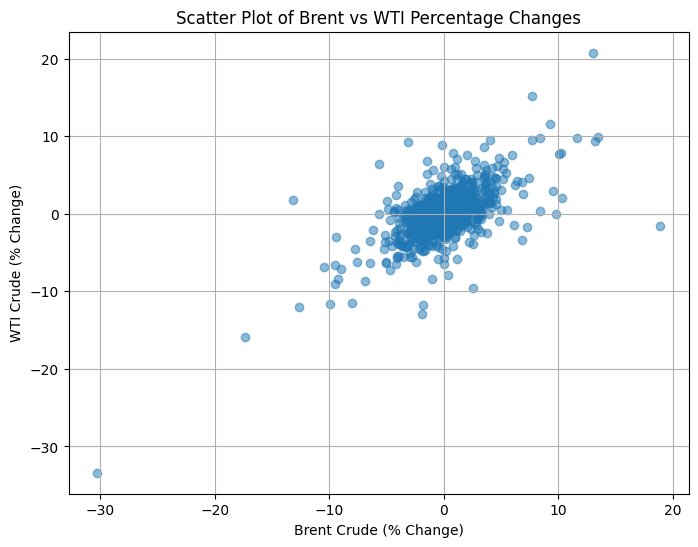

In [7]:
# Calculate Pearson correlation
correlation = stationary_data[['y_brent_pct', 'y_wti_pct']].corr()

# Display the correlation matrix
print("Correlation between Brent and WTI percentage changes:")
print(correlation)

# Plot a scatter plot to visualize the relationship
plt.figure(figsize=(8, 6))
plt.scatter(stationary_data['y_brent_pct'], stationary_data['y_wti_pct'], alpha=0.5)
plt.title('Scatter Plot of Brent vs WTI Percentage Changes')
plt.xlabel('Brent Crude (% Change)')
plt.ylabel('WTI Crude (% Change)')
plt.grid(True)
plt.show()

The correlation suggests that changes in WTI prices are moderately to strongly linked to changes in Brent prices within this subset of data.

This correlation indicates that a VAR model could effectively utilize WTI's past percentage changes to predict Brent's future percentage changes (and vice versa).

In [8]:
from statsmodels.tsa.stattools import grangercausalitytests

# Test Granger causality (does WTI cause Brent?)
granger_result = grangercausalitytests(
    stationary_data[['y_brent_pct', 'y_wti_pct']], maxlag=4, verbose=True
)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=91.6423 , p=0.0000  , df_denom=995, df_num=1
ssr based chi2 test:   chi2=91.9187 , p=0.0000  , df=1
likelihood ratio test: chi2=87.9289 , p=0.0000  , df=1
parameter F test:         F=91.6423 , p=0.0000  , df_denom=995, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=45.4628 , p=0.0000  , df_denom=992, df_num=2
ssr based chi2 test:   chi2=91.3839 , p=0.0000  , df=2
likelihood ratio test: chi2=87.4353 , p=0.0000  , df=2
parameter F test:         F=45.4628 , p=0.0000  , df_denom=992, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=31.5521 , p=0.0000  , df_denom=989, df_num=3
ssr based chi2 test:   chi2=95.3262 , p=0.0000  , df=3
likelihood ratio test: chi2=91.0361 , p=0.0000  , df=3
parameter F test:         F=31.5521 , p=0.0000  , df_denom=989, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=23.4677 , p=0.0000  

/usr/local/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


Lag 1: WTI's percentage changes at lag 1 strongly influence Brent's percentage changes.
Lag 2, 3, and 4: Higher lags also show significant Granger causality, but the influence diminishes with increasing lag length (as seen from the decreasing F-statistics).

This suggests that a VAR model incorporating lagged WTI changes (1 to 4 lags) could effectively predict Brent's changes.

# VAR estimation

In [9]:
from statsmodels.tsa.api import VAR

# Reserve 80% of the data for training
train_size = int(0.8 * stationary_data.shape[0])
train_data = stationary_data[['y_brent_pct', 'y_wti_pct']].iloc[:train_size]
test_data = stationary_data[['y_brent_pct', 'y_wti_pct']].iloc[train_size:]

var_model = VAR(train_data)

# Select the optimal lag order using AIC
lag_selection = var_model.select_order(maxlags=15)  # Test lag orders up to 15
optimal_lag = lag_selection.aic
print(f"Optimal Lag Order (based on AIC): {optimal_lag}")

fitted_model = var_model.fit(optimal_lag)
print(fitted_model.summary())

# Save the fitted model for future use
fitted_model.save("var_model_1000_samples.pkl")

Optimal Lag Order (based on AIC): 7
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 01, Dec, 2024
Time:                     17:52:44
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    2.56019
Nobs:                     792.000    HQIC:                   2.45118
Log likelihood:          -3161.32    FPE:                    10.8388
AIC:                      2.38312    Det(Omega_mle):         10.4396
--------------------------------------------------------------------
Results for equation y_brent_pct
                    coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------------
const                 -0.016516         0.066052           -0.250           0.803
L1.y_brent_pct        -0.234634         0.044337           -5.292           0.000
L1.y_wti_pct  

/usr/local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


The optimal lag order for the VAR model, determined by AIC, is 7.

# VAR forecasts

/usr/local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dat

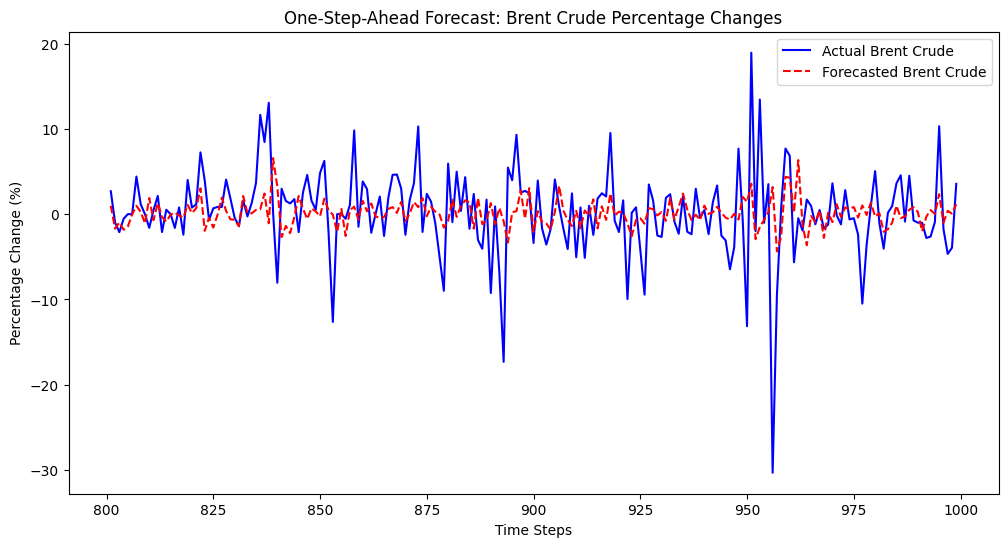

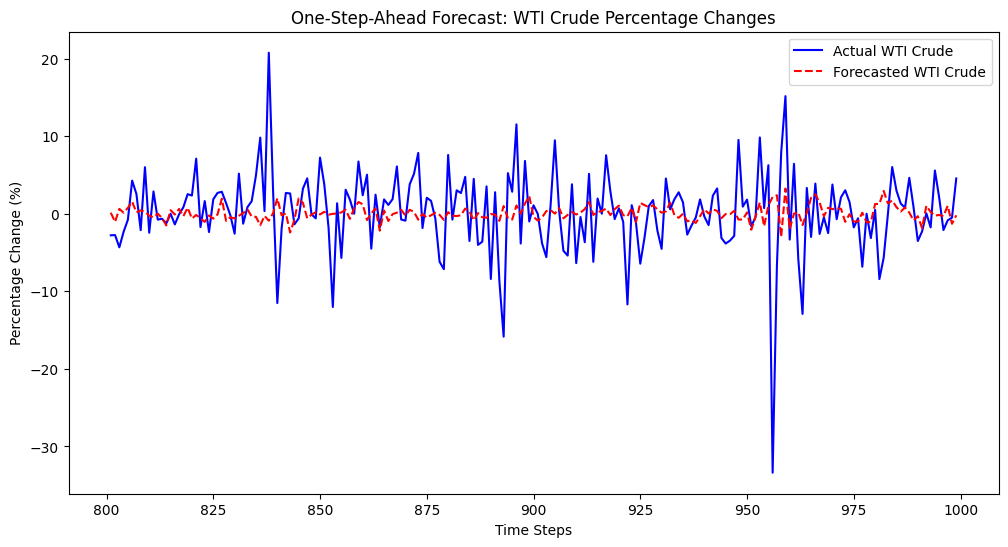

Evaluation Metrics:
RMSE: {'Brent': 5.08145382524515, 'WTI': 5.3728764189822025}
MAE: {'Brent': 3.3944291328100324, 'WTI': 3.6382707575153064}
RMSPE: {'Brent': 29.193083793109295, 'WTI': 29.198227692870855}


In [10]:
from statsmodels.tools.eval_measures import rmse, meanabs, rmspe

# Prepare data for one-step-ahead forecasting
Y = stationary_data[['y_brent_pct', 'y_wti_pct']]  # Select variables for VAR modeling
n = Y.shape[0]  # Total number of observations
n_fcs = int(0.2 * n)  # Reserve the last 20% for forecasting

# Placeholder for forecasts
fcs = np.empty((n_fcs, 2))
fcs[:] = np.nan

# Perform rolling one-step-ahead forecasts using optimal lag
for i in range(n_fcs):
    rolling_train = Y.iloc[:(n - (n_fcs - i))]  # Use all data up to the current point for training
    var_model = VAR(rolling_train)  # Declare VAR model
    fitted_model = var_model.fit(optimal_lag)  # Fit VAR model with optimal lag
    fcs_i = fitted_model.forecast(y=rolling_train.values, steps=1)  # Generate a one-step-ahead forecast
    fcs[i, :] = fcs_i  # Store forecasted values

# Convert forecasts to a DataFrame
forecast_df = pd.DataFrame(fcs, index=Y.iloc[-n_fcs:].index, columns=['y_brent_pct_forecast', 'y_wti_pct_forecast'])

# Extract actual test data
actual_test = Y.iloc[-n_fcs:]

# Combine actual and forecasted values for evaluation
validation_results = pd.concat([actual_test.reset_index(drop=True), forecast_df.reset_index(drop=True)], axis=1)

# Plot actual vs forecasted values for Brent Crude
plt.figure(figsize=(12, 6))
plt.plot(actual_test.index, actual_test['y_brent_pct'], label='Actual Brent Crude', color='blue')
plt.plot(forecast_df.index, forecast_df['y_brent_pct_forecast'], label='Forecasted Brent Crude', linestyle='--', color='red')
plt.title('One-Step-Ahead Forecast: Brent Crude Percentage Changes')
plt.xlabel('Time Steps')
plt.ylabel('Percentage Change (%)')
plt.legend()
plt.show()

# Plot actual vs forecasted values for WTI Crude
plt.figure(figsize=(12, 6))
plt.plot(actual_test.index, actual_test['y_wti_pct'], label='Actual WTI Crude', color='blue')
plt.plot(forecast_df.index, forecast_df['y_wti_pct_forecast'], label='Forecasted WTI Crude', linestyle='--', color='red')
plt.title('One-Step-Ahead Forecast: WTI Crude Percentage Changes')
plt.xlabel('Time Steps')
plt.ylabel('Percentage Change (%)')
plt.legend()
plt.show()

rmse_vals = {
    "Brent": rmse(actual_test['y_brent_pct'], forecast_df['y_brent_pct_forecast']),
    "WTI": rmse(actual_test['y_wti_pct'], forecast_df['y_wti_pct_forecast'])
}
mae_vals = {
    "Brent": meanabs(actual_test['y_brent_pct'], forecast_df['y_brent_pct_forecast']),
    "WTI": meanabs(actual_test['y_wti_pct'], forecast_df['y_wti_pct_forecast'])
}
rmspe_vals = {
    "Brent": rmspe(actual_test['y_brent_pct'], forecast_df['y_brent_pct_forecast']),
    "WTI": rmspe(actual_test['y_wti_pct'], forecast_df['y_wti_pct_forecast'])
}

print("Evaluation Metrics:")
print("RMSE:", rmse_vals)
print("MAE:", mae_vals)
print("RMSPE:", rmspe_vals)

The evaluation metrics for the one-step-ahead forecasts show the difficulty of predicting changes in Brent and WTI crude oil prices. The RMSE values (Brent: 5.08, WTI: 5.37) indicate moderate errors, while the MAE values (Brent: 3.39, WTI: 3.64) show that the average difference between actual and forecasted values is noticeable. The RMSPE values (Brent: 29.19%, WTI: 29.20%) highlight the challenges of forecasting such volatile data, with large relative errors. These results confirm that while the model captures general trends, predicting sudden changes or turning points is particularly challenging, making it hard to achieve high precision.

# Bonus

/usr/local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


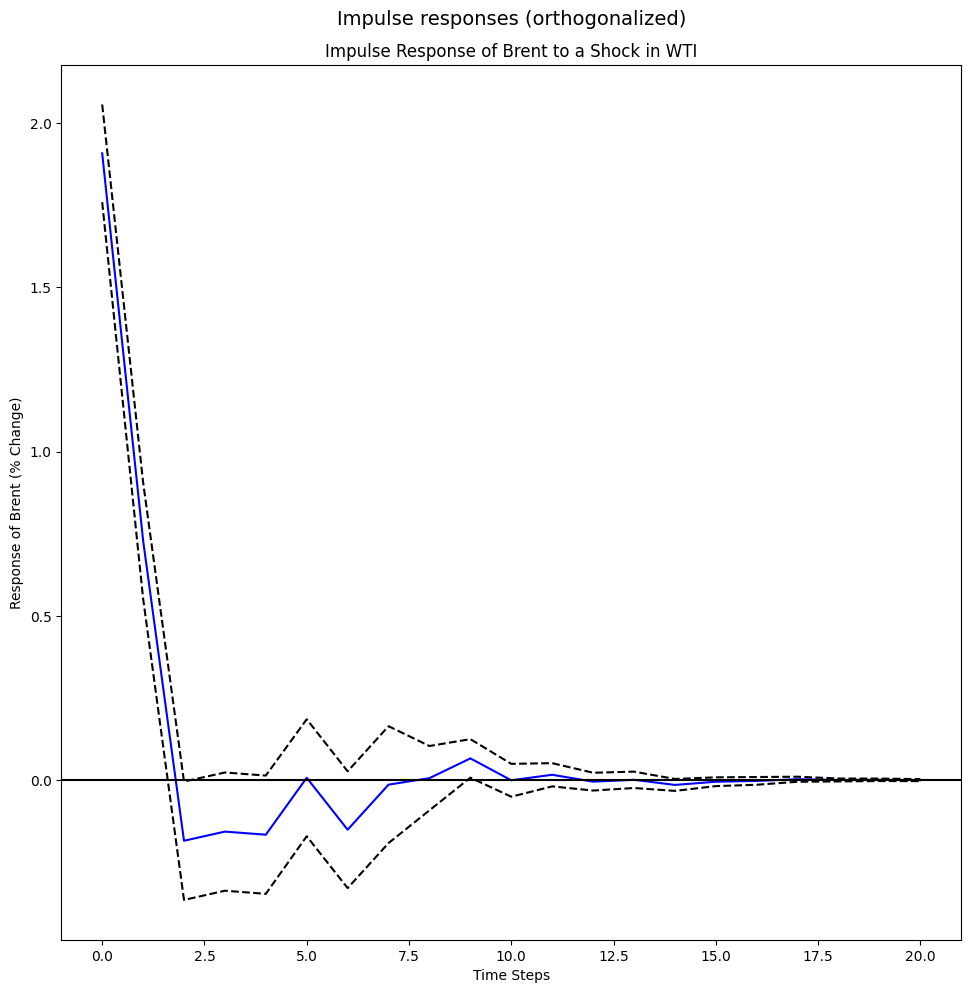

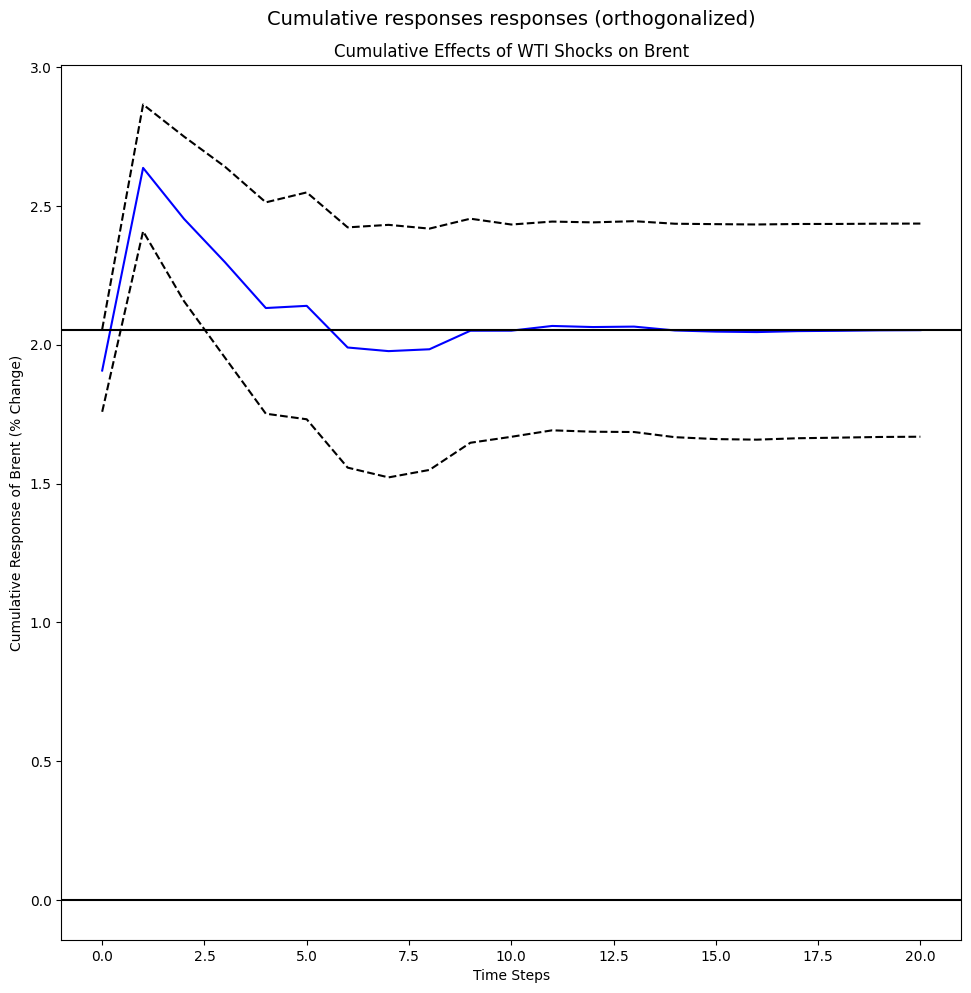

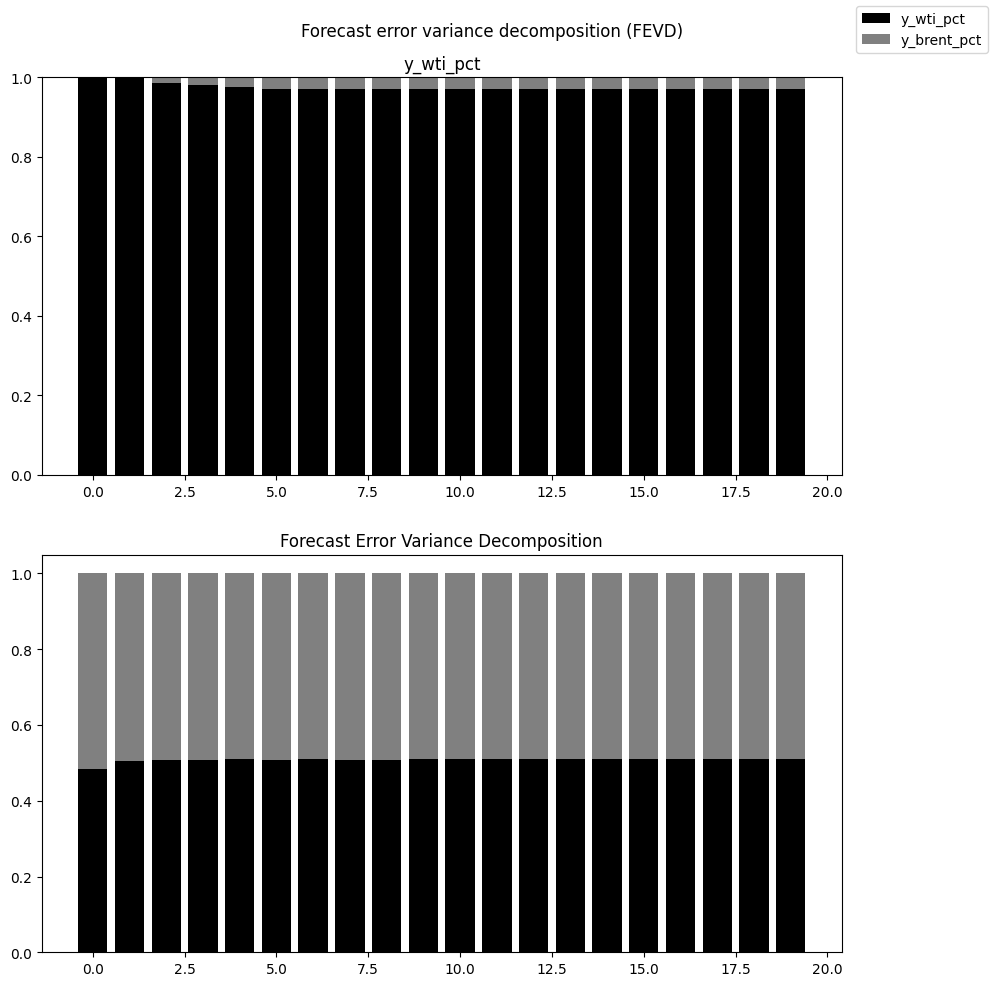

FEVD for y_wti_pct
      y_wti_pct  y_brent_pct
0      1.000000     0.000000
1      0.997628     0.002372
2      0.985033     0.014967
3      0.980691     0.019309
4      0.976591     0.023409
5      0.971586     0.028414
6      0.970787     0.029213
7      0.969925     0.030075
8      0.969870     0.030130
9      0.969620     0.030380
10     0.969606     0.030394
11     0.969580     0.030420
12     0.969578     0.030422
13     0.969578     0.030422
14     0.969577     0.030423
15     0.969573     0.030427
16     0.969573     0.030427
17     0.969572     0.030428
18     0.969572     0.030428
19     0.969572     0.030428

FEVD for y_brent_pct
      y_wti_pct  y_brent_pct
0      0.483723     0.516277
1      0.506165     0.493835
2      0.507695     0.492305
3      0.507606     0.492394
4      0.509067     0.490933
5      0.507799     0.492201
6      0.509056     0.490944
7      0.508799     0.491201
8      0.508690     0.491310
9      0.508947     0.491053
10     0.508935     0.491065
11

In [11]:
# Reorder variables: WTI first, Brent second
Y_reordered = stationary_data[['y_wti_pct', 'y_brent_pct']]  # Reorder variables

# Fit VAR model with optimal lag
var_full = VAR(Y_reordered)
res = var_full.fit(optimal_lag)  # Use previously determined optimal lag

# Compute impulse response functions for 20 steps ahead
irf = res.irf(20)

# Plot impulse response of Brent to a shock in WTI
irf.plot(impulse='y_wti_pct', response='y_brent_pct', orth=True)
plt.title("Impulse Response of Brent to a Shock in WTI")
plt.xlabel("Time Steps")
plt.ylabel("Response of Brent (% Change)")
plt.show()

# Plot cumulative effects of WTI shocks on Brent
irf.plot_cum_effects(impulse='y_wti_pct', response='y_brent_pct', orth=True)
plt.title("Cumulative Effects of WTI Shocks on Brent")
plt.xlabel("Time Steps")
plt.ylabel("Cumulative Response of Brent (% Change)")
plt.show()

# Forecast Error Variance Decomposition (FEVD)
fevd = res.fevd(20)
fevd.plot()
plt.title("Forecast Error Variance Decomposition")
plt.show()
print(fevd.summary())


The Forecast Error Variance Decomposition (FEVD) and impulse response plots reveal the dynamics between WTI and Brent crude oil prices. For WTI percentage changes (y_wti_pct), nearly all the forecast error variance (over 97% by step 19) is explained by its own shocks, indicating that WTI operates largely independently of Brent. In contrast, for Brent percentage changes (y_brent_pct), about 50% of the forecast error variance is consistently explained by shocks to WTI, highlighting WTI's strong influence on Brent over time.

The impulse response plots further reinforce this relationship. A one-unit shock in WTI results in an immediate and significant response in Brent, peaking around 2% in the first time step and decaying quickly as the impact stabilizes close to zero after a few periods. The cumulative response plot shows that the long-term cumulative effect of WTI shocks on Brent stabilizes around 2%, reflecting the sustained influence of WTI on Brent despite diminishing short-term impacts. These findings underline WTI's role as a driving force in global crude oil markets, while Brent exhibits a stronger dependency on WTI's dynamics.